# Projet 1 - Segmentation du réseau vasculaire dans des images de rétine

## Chargement des librairies et données

In [1]:
import cv2
import glob
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from scipy import ndimage as ndi
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat, disk, square, 
                                black_tophat, thin, diameter_opening)
from skimage.filters import threshold_otsu, gaussian, meijering, median
from skimage.util import img_as_float, img_as_ubyte
from skimage import feature
from skimage.exposure import equalize_adapthist
from tqdm.notebook import tqdm

In [2]:
im_files = sorted(glob.glob('./images_IOSTAR/*.jpg'))
gt_files = sorted(glob.glob('./images_IOSTAR/*.png'))
len(im_files)

10

<u>10 images à traiter</u> :

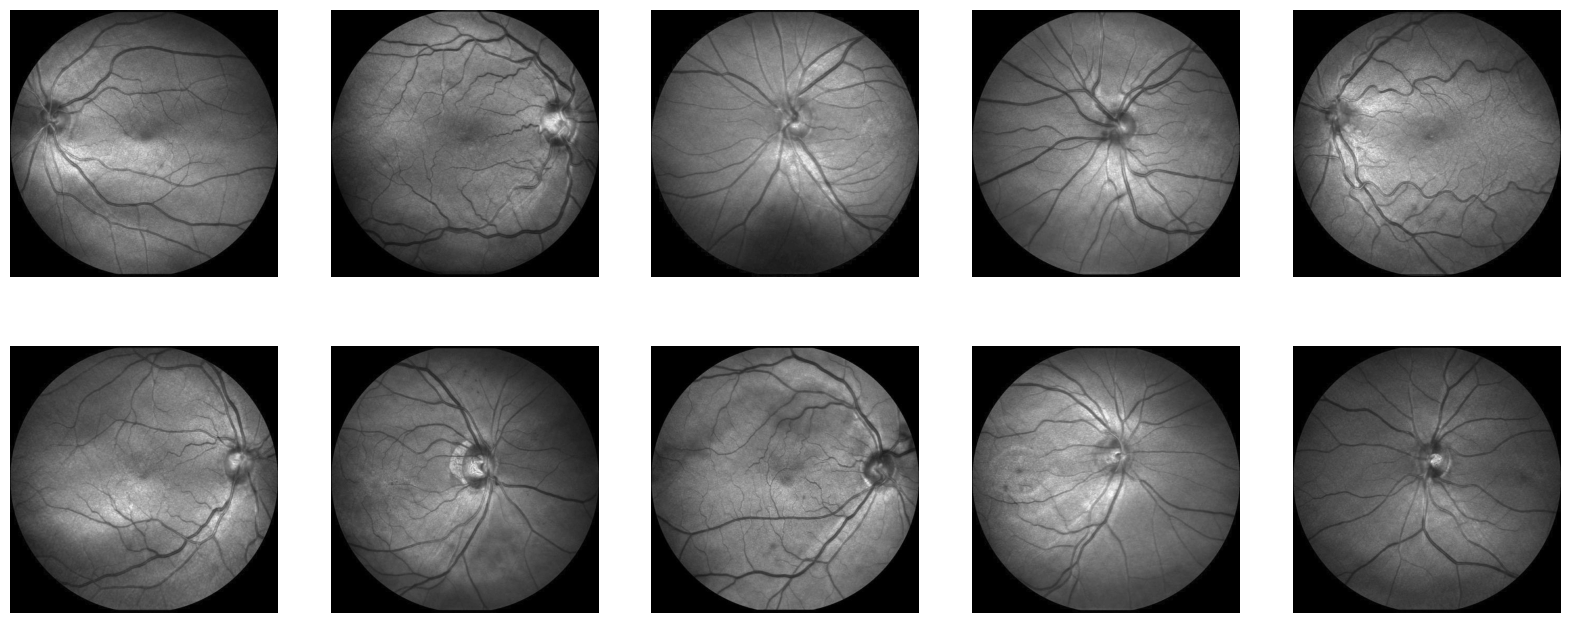

In [3]:
plt.figure(figsize=(20, 8))
for i in range(len(im_files)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(im_files[i])), cmap="gray")
    plt.axis('off')
plt.show()

<u>Segmentations expertes des 10 images, auxquelles comparer les résultats</u> :

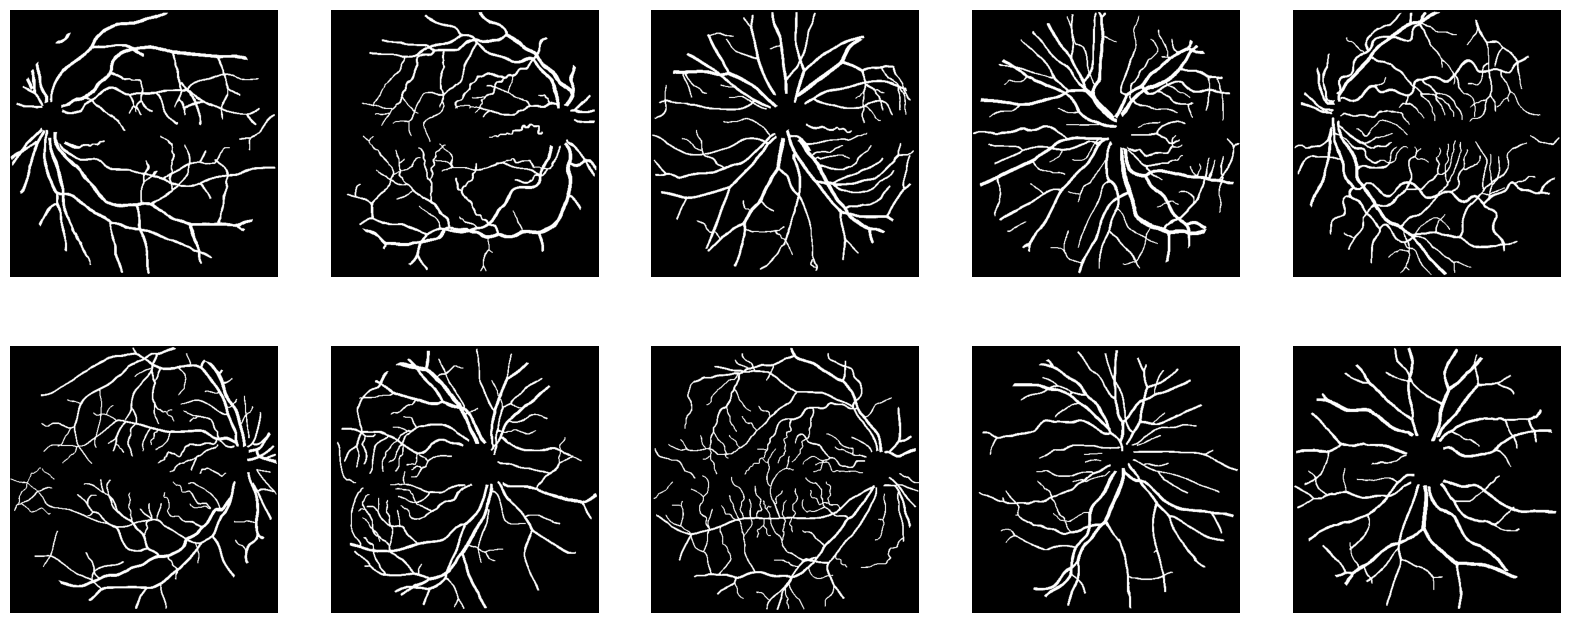

In [4]:
plt.figure(figsize=(20, 8))
for i in range(len(im_files)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(gt_files[i])), cmap="gray")
    plt.axis('off')
plt.show()

## Fonctions d'évaluation

In [5]:
# Fonction proposée dans l'énoncé
def evaluate(img_out, img_GT):
    GT_skel  = thin(img_GT, max_num_iter = 15) # On suppose que la demie epaisseur maximum
    img_out_skel  = thin(img_out, max_num_iter = 15) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel

In [6]:
# Ajout du calcul du F1-score car plus aisé de travailler avec une seule métrique à optimiser
# (en particulier car l'amélioration du score d'une métrique revient en général à abaisser le score de l'autre)
def f1_eval(img_out, img_GT):
    GT_skel  = thin(img_GT, max_num_iter = 15) # On suppose que la demie epaisseur maximum
    img_out_skel  = thin(img_out, max_num_iter = 15) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    F1 = 2*TP / (2*TP + FP + FN) # F1-Score : moyenne harmonique de la precision et du rappel
    return ACCU, RECALL, F1

## Algorithme de segmentation

In [7]:
def my_segmentation(img_src, l=3):
    """ Segmente les vaisseaux sanguins d'une image de rétine fournie en entrée
    Args:
        img_src (array numpy) : image à segmenter
        l (int) : dimension des filtres linéaires utilisés pour isoler les lignes de l'image
    Return:
        segmented (array numpy) : image segmentée
    """
    # Filtre median sur l'image originale pour retirer une partie du bruit initial
    med = median(img_src)
    # Suppression du background via un black top hat
    hat = black_tophat(med, disk(4))
    # Augmentation du contraste local de l'image (algorithme CLAHE)
    rescale = equalize_adapthist(hat, kernel_size=32)
    # Débruitage du background
    meij = meijering(rescale, range(1,5), black_ridges=False)
    # Seuillage d'Otsu pour binariser l'image
    thresh = threshold_otsu(meij)
    otsu = meij > thresh
    
    # Filtres pour détecter les vaisseaux sanguins
    # Détecte lignes diagonales proportionnelles à la matrice identité
    linefilter1 = -1 * np.eye(l)
    linefilter1 = erosion(linefilter1, disk(1)) + 3 * np.eye(l)
    # Diagonale dans l'autre sens
    linefilter2 = linefilter1[::-1]
    # Détecte les lignes verticales
    linefilter3 = np.zeros((l,l))
    linefilter3[:,int((l-1)/2)] = 2
    linefilter3[:,int((l-1)/2)+1], linefilter3[:,int((l-1)/2)-1] = -1, -1
    # Détecte les lignes horizontales
    linefilter4 = linefilter3.T
    conv1 = ndi.convolve(otsu, linefilter1)
    conv2 = ndi.convolve(otsu, linefilter2)
    conv3 = ndi.convolve(otsu, linefilter3)
    conv4 = ndi.convolve(otsu, linefilter4)
    # Combinaison des 4 images obtenues après convolution
    combine = conv1 + conv2 + conv3 + conv4
    
    # Filtrage des artefacts : reste du contour de l'oeil, etc.
    mask = np.zeros(combine.shape, dtype="uint8")
    cv2.rectangle(mask, (15, 15), (505, 505), 255, -1)
    thins = cv2.bitwise_and(combine*255, combine*255, mask=mask)
    # Fermeture pour boucher les vaisseaux
    clos = closing(thins, disk(1))
    # Suppression de quelques éléments isolés (non connexes à des vaisseaux)
    segmented = diameter_opening(clos, diameter_threshold=9)
    
    return segmented

## Résultats obtenus sur les 10 images fournies

  0%|          | 0/10 [00:00<?, ?it/s]

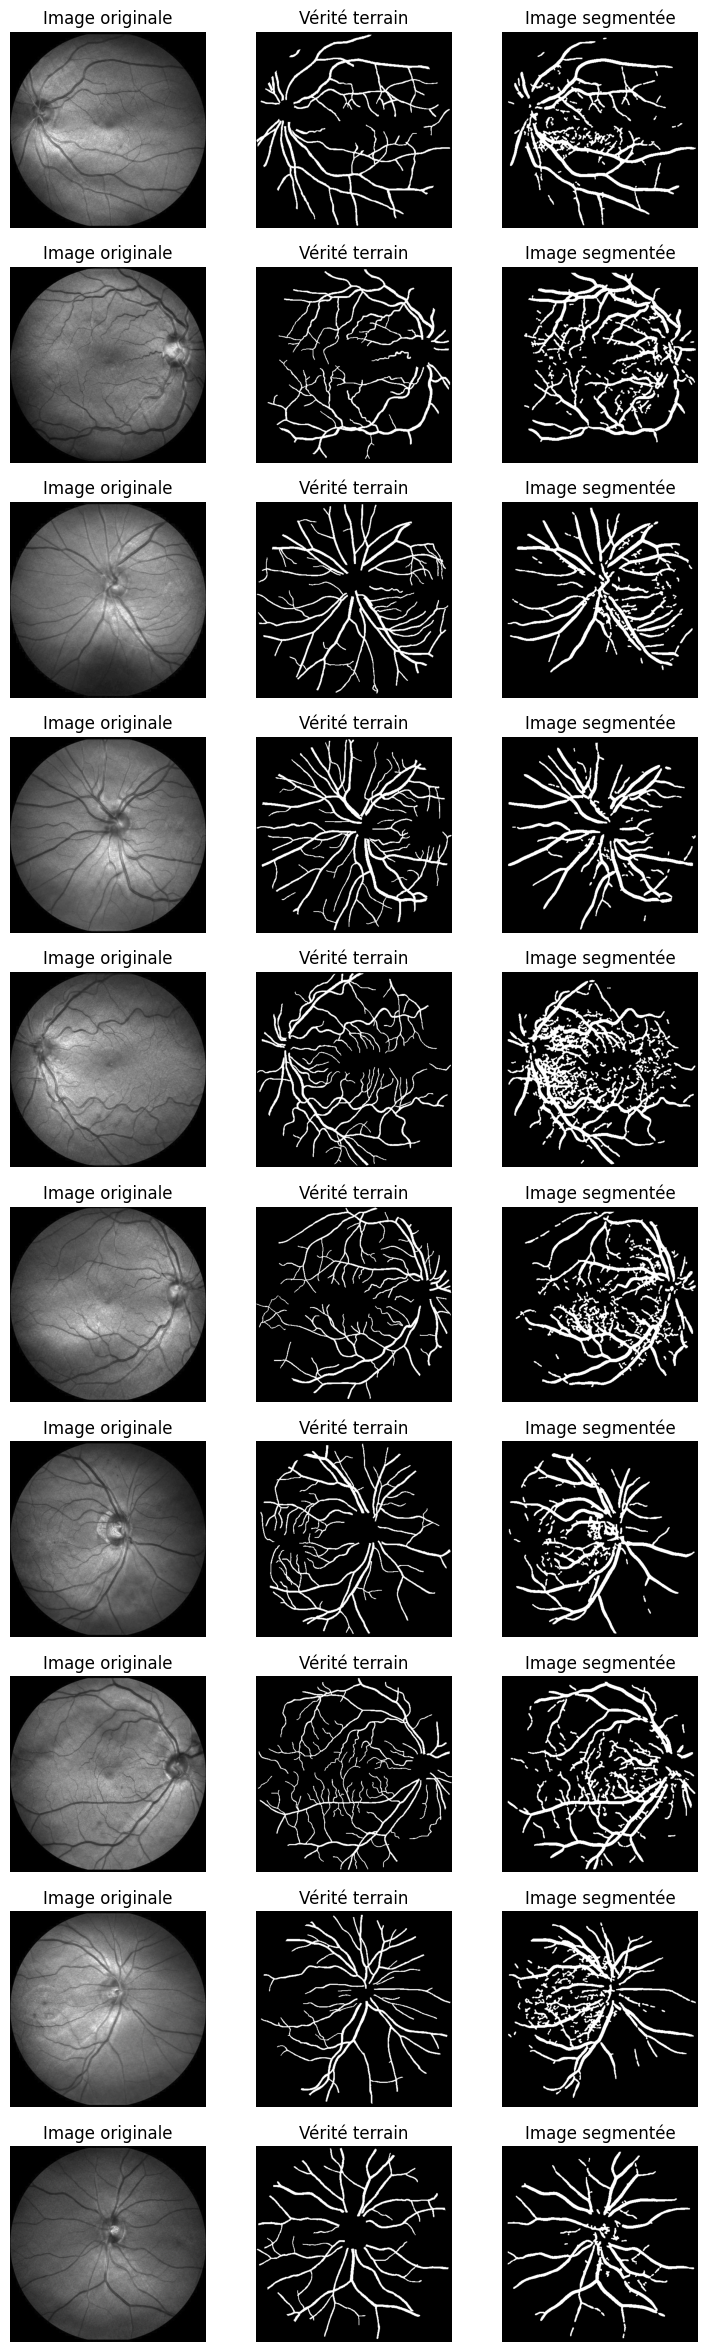

In [8]:
plt.figure(figsize=(9, 30))
prec, recall, f1 = [], [], []
for i in tqdm(range(len(im_files))):
    plt.subplot(10, 3, 3*i +1)
    plt.imshow(np.array(Image.open(im_files[i])), cmap="gray")
    plt.title("Image originale")
    plt.axis('off')
    plt.subplot(10, 3, 3*i +2)
    plt.imshow(np.array(Image.open(gt_files[i])), cmap="gray")
    plt.title("Vérité terrain")
    plt.axis('off')
    plt.subplot(10, 3, 3*i +3)
    seg = my_segmentation(np.array(Image.open(im_files[i])))
    plt.imshow(seg, cmap="gray")
    plt.title("Image segmentée")
    plt.axis('off')
    tmpp, tmpr, tmpf = f1_eval(seg, np.array(Image.open(gt_files[i])))
    prec.append(tmpp)
    recall.append(tmpr)
    f1.append(tmpf)
plt.show()

In [9]:
table = []
for i, f in enumerate(im_files):
    name = f.split("/")[-1].split(".")[0]
    tmp = [name, f"{prec[i]:.2f}", f"{recall[i]:.2f}", f"{f1[i]:.2f}"]
    table.append(tmp)
table.append(["Scores moyens", f"{np.mean(prec):.2f}", f"{np.mean(recall):.2f}", f"{np.mean(f1):.2f}"])
table = pd.DataFrame(table, columns =['Image', 'Précision', 'Rappel', 'F1-Score'])
table.index=[''] * len(table)
table

,Image,Précision,Rappel,F1-Score
,star01_OSC,0.77,0.76,0.77
,star02_OSC,0.75,0.85,0.79
,star03_OSN,0.85,0.69,0.76
,star08_OSN,0.94,0.65,0.77
,star21_OSC,0.61,0.74,0.67
,star26_ODC,0.68,0.73,0.71
,star28_ODN,0.81,0.64,0.71
,star32_ODC,0.82,0.78,0.80
,star37_ODN,0.71,0.76,0.74
,star48_OSN,0.87,0.76,0.81


## Fonctionnement détaillé de l'algorithme sur un exemple

Exemple avec la 1ère image (star01_OSC)

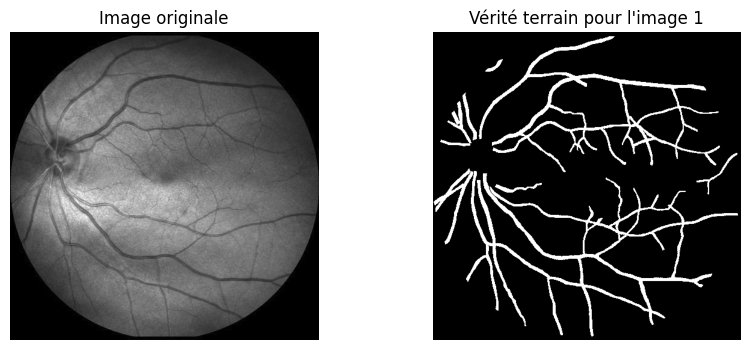

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
img = np.array(Image.open(im_files[0]))
plt.imshow(img, cmap="gray")
plt.title("Image originale")
plt.axis('off')
plt.subplot(1,2,2)
gt = np.array(Image.open(gt_files[0]))
plt.imshow(gt, cmap="gray")
plt.title("Vérité terrain pour l'image 1")
plt.axis('off')
plt.show()

Une première étape de pre-processing consiste à supprimer une partie du bruit. Un filtre médiane est appliqué pour cela (donne empiriquement de meilleurs résultats qu'un filtre gaussien). L'image générée n'a pas l'air très différente de l'image initiale, mais cela a un impact non négligeable sur le nombre de tâches blanches visibles sur les images suivantes par la suite. <br>
Le fond étant clair de manière assez uniforme, et les vaisseaux sanguins foncés, une transformation top-hat permet de réaliser un premier niveau de segmentation. Un disque de rayon 4 a été choisi comme élément structurant. L'augmentation du rayon permet de faire ressortir plus facilement les vaisseaux sanguins ... mais également l'iris, et d'autres tâches blanches parasites (bord de l'oeil). Une valeur entre 4 et 8 semble un bon compromis. Une étape de remise à l'échelle du niveau de gris via algorithme CLAHE permet par la suite de mieux faire ressortir les vaisseaux. Cet algorithme améliore le contraste même dans les régions très sombres ou éclairées de l'image.

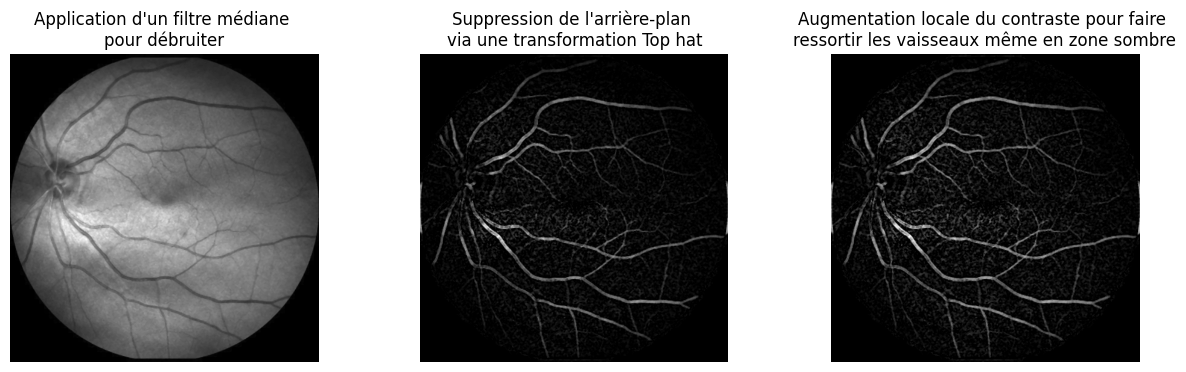

In [11]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
med = median(img)
plt.imshow(med, cmap="gray")
plt.axis('off')
plt.title("Application d'un filtre médiane \npour débruiter")
plt.subplot(1,3,2)
hat = black_tophat(med, disk(4))
plt.imshow(hat, cmap="gray")
plt.axis('off')
plt.title("Suppression de l'arrière-plan \nvia une transformation Top hat")
plt.subplot(1,3,3)
rescale = equalize_adapthist(hat, kernel_size=32)
plt.title("Augmentation locale du contraste pour faire \nressortir les vaisseaux même en zone sombre")
plt.imshow(rescale, cmap="gray")
plt.axis('off')
plt.show()

L'augmentation du contraste rend certes les vaisseaux plus visibles, mais augmente également le bruit de l'arrière-plan. L'application d'un filtre de Meijering permet de faire diminuer le bruit de fond et de bien délimiter les vaisseaux. <br>
L'application d'un seuil d'Otsu est ensuite une méthode classique de binarisation de l'image.

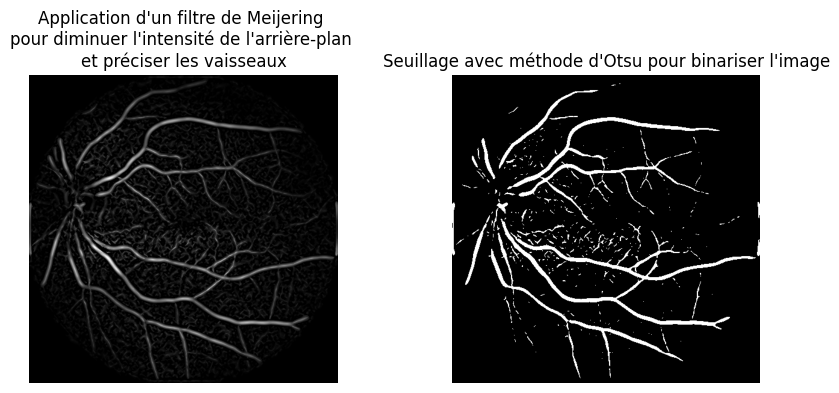

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
meij = meijering(rescale, range(1,5), black_ridges=False)
plt.imshow(meij, cmap="gray")
plt.title("Application d'un filtre de Meijering \npour diminuer l'intensité de l'arrière-plan \net préciser les vaisseaux")
plt.axis('off')
plt.subplot(1,2,2)
thresh = threshold_otsu(meij)
otsu = meij > thresh
plt.imshow(otsu, cmap="gray")
plt.title("Seuillage avec méthode d'Otsu pour binariser l'image")
plt.axis('off')
plt.show()

A partir de cette étape, les vaisseaux épais sont bien segmentés, et le bruit de fond semble relativement aisé à supprimer via une ouverture. Le challenge se porte donc plutôt sur la segmentation des vaisseaux fins, qui seront perdus si on réalise effectivement une ouverture pour supprimer le bruit. <br>
Pour les segmenter, j'ai réalisé 4 filtres linéaires pour récupérer les lignes horizontales, verticales et diagonales. Pour détecter les petits vaisseaux, une seule ligne doit contenir des valeurs positives dans les filtres. J'ai testé plusieurs tailles de filtre : des kernels de taille 3x3 donnent des résultats convenables (tout du moins meilleurs qu'avec des filtres trop grands).

In [13]:
# Permet de jouer sur la taille des filtres
l = 3

# Détecte lignes diagonales proportionnelles à l'identité
linefilter1 = -1 * np.eye(l)
linefilter1 = erosion(linefilter1, disk(1)) + 3 * np.eye(l)
# Diagonale dans l'autre sens
linefilter2 = linefilter1[::-1]

# Détecte les lignes verticales
linefilter3 = np.zeros((l,l))
linefilter3[:,int((l-1)/2)] = 2
linefilter3[:,int((l-1)/2)+1], linefilter3[:,int((l-1)/2)-1] = -1, -1
# Détecte les lignes horizontales
linefilter4 = linefilter3.T

linefilter1, linefilter2, linefilter3, linefilter4

(array([[ 2., -1.,  0.],
        [-1.,  2., -1.],
        [ 0., -1.,  2.]]),
 array([[ 0., -1.,  2.],
        [-1.,  2., -1.],
        [ 2., -1.,  0.]]),
 array([[-1.,  2., -1.],
        [-1.,  2., -1.],
        [-1.,  2., -1.]]),
 array([[-1., -1., -1.],
        [ 2.,  2.,  2.],
        [-1., -1., -1.]]))

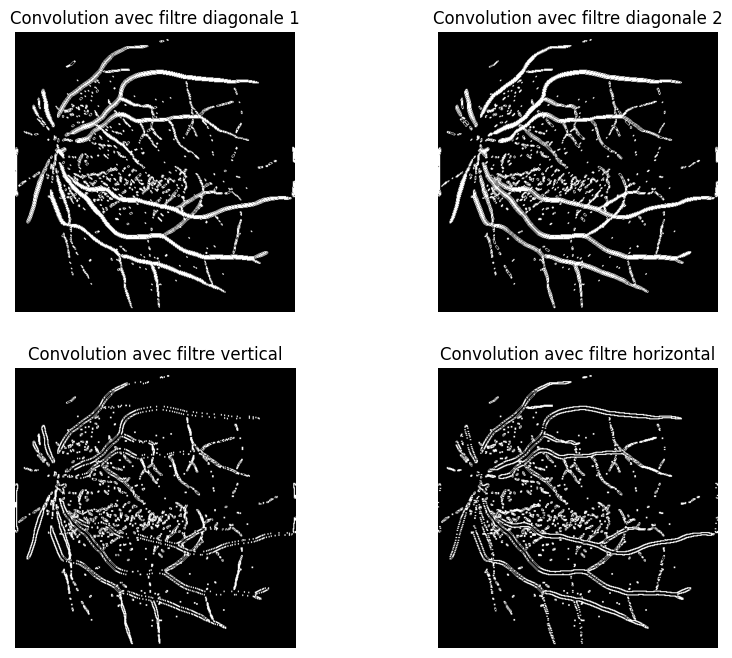

In [14]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
lin1 = ndi.convolve(otsu, linefilter1)
plt.imshow(lin1, cmap="gray")
plt.axis('off')
plt.title("Convolution avec filtre diagonale 1")
plt.subplot(2,2,2)
lin2 = ndi.convolve(otsu, linefilter2)
plt.imshow(lin2, cmap="gray")
plt.axis('off')
plt.title("Convolution avec filtre diagonale 2")
plt.subplot(2,2,3)
lin3 = ndi.convolve(otsu, linefilter3)
plt.imshow(lin3, cmap="gray")
plt.axis('off')
plt.title("Convolution avec filtre vertical")
plt.subplot(2,2,4)
lin4 = ndi.convolve(otsu, linefilter4)
plt.imshow(lin4, cmap="gray")
plt.axis('off')
plt.title("Convolution avec filtre horizontal")
plt.show()

Travailler avec la somme des 4 images obtenues permet de recréer une partie des petits vaisseaux sanguins. <br>
Un masque rectangulaire est ensuite appliqué pour supprimer les artefacts aux bords de l'image. <br>

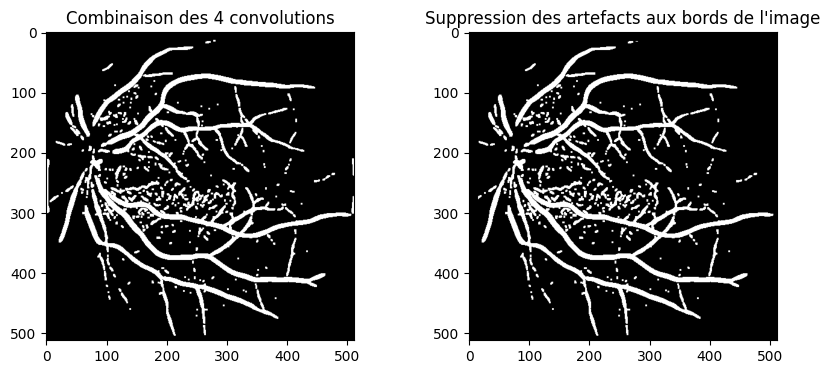

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
combine = lin1 + lin2 + lin3 + lin4
plt.imshow(combine, cmap="gray")
plt.title("Combinaison des 4 convolutions")
plt.subplot(1,2,2)
mask = np.zeros(combine.shape, dtype="uint8")
cv2.rectangle(mask, (15, 15), (505, 505), 255, -1)
thins = cv2.bitwise_and(combine*255, combine*255, mask=mask)
plt.imshow(thins, cmap="gray")
plt.title("Suppression des artefacts aux bords de l'image")
plt.show()

Une fermeture est ensuite appliquée (élément structurant disque de rayon 1) pour tenter de boucher les trous au milieu des vaisseaux sanguins sans trop déformer l'image. Finalement, une ouverture est appliquée pour tenter de supprimer les dernières traces de bruit présentes au milieu de l'image.

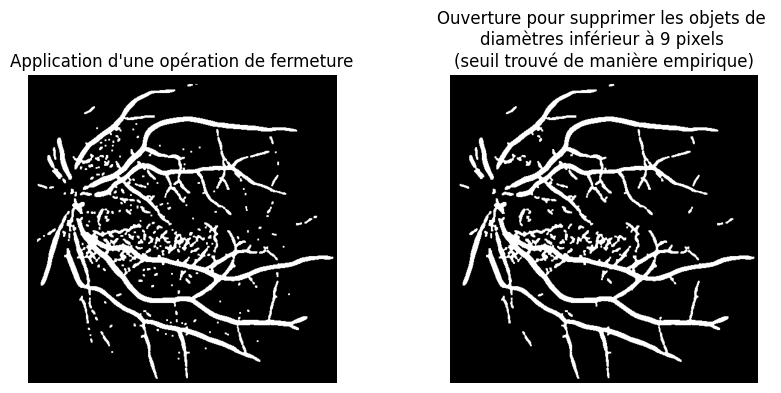

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
clos = closing(thins, disk(1))
plt.imshow(clos, cmap="gray")
plt.axis('off')
plt.title("Application d'une opération de fermeture")
plt.subplot(1,2,2)
dop = diameter_opening(clos, diameter_threshold=9)
plt.imshow(dop, cmap="gray")
plt.title("Ouverture pour supprimer les objets de \ndiamètres inférieur à 9 pixels \n(seuil trouvé de manière empirique)")
plt.axis('off')
plt.show()